In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#From signac
import signac
date_time_str = None
meth_name_str_list = [1, 2, 3, 4, 5]
study_id = "ep"
save_csv = False


criteria_dict = {"cs_name_val" : 1,
                 "param_name_str" : "t1t2",
                 "retrain_GP": 5,
                 "num_x_data": 5,
                 "num_val_pts": 20,
                 "lenscl": None}

df = pd.DataFrame()
job_list = []
for meth_name_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_name_val
    df_piece, jobs, name_cs_str, theta_true = get_study_data_signac(criteria_dict, study_id, save_csv)
    job_list += [job for job in jobs]
#     df_best = get_best_data(df_piece, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
    df = pd.concat([df, df_piece], ignore_index=True)
    
# df = df[df['EP Method Val'] == 4]

In [3]:
### Get Best Data from ep experiment
save_csv = False
df_best = get_best_data(df, study_id, name_cs_str, theta_true, job_list, date_time_str, save_csv)
df_best

# save_path = "Results/" + study_id + "_study/" + cs_name + "/" + param_name_str + "/" +  study_id + "_study_best.csv"
# df_best.to_csv(save_path, header = True)
# #Get Mean Data from ep experiment
# df_mean = get_mean_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_mean

# #Get Median Data from ep experiment
# df_median = get_median_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)

# #Get Median of Best Data from ep experiment
# df_median_best = get_median_data(df_best, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_median_best

,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter,EP Method Val,BO Method,Max Evals,Total Run Time,L2 Norm Theta
11,5,1,5.342819,0.666667,0.0,"[-1.1923314387327575, 1.2550420118452932]",0.86575,0.078749,"[1.0622882964925582, -0.9657215500034723]",0.078749,"[1.0622882964925582, -0.9657215500034723]",0.14952,3,A1,2,0.299039,0.071097
240,7,1,1.675753,1.0,0.0,"[-0.12469795110750015, 1.8446633771315404]",1.337255,-1.118795,"[0.9078567554482146, -0.9156740615532917]",-1.118795,"[0.9078567554482146, -0.9156740615532917]",0.107567,1,B1,2,0.215134,0.124905
499,3,4,0.000002,2.0,0.000002,"[1.0001750084083774, -0.9997719454291544]",0.0,0.000001,"[1.0001041838227045, -0.9998630819205805]",0.000001,"[1.0001041838227045, -0.9998630819205805]",1.737641,4,A2,5,8.688207,0.000172
5137,13,99,-20.831986,0.5,4.253996,"[1.000003510958464, -0.9999952747577525]",-23.00006,-21.056092,"[1.0000037983732255, -0.9999958961327475]",-21.056092,"[1.0000037983732255, -0.9999958961327475]",73.386999,3,B2,100,7338.699937,0.000006
5271,1,1,5.342819,1.124104,0.0,"[-0.9023643249400515, 1.009907260734813]",0.000554,0.006628,"[1.025695915986367, -0.9991365280015173]",0.006628,"[1.025695915986367, -0.9991365280015173]",15.352817,4,C2,2,30.705635,0.025710


In [4]:
#Get only the jobs which are the best
project = signac.get_project()
job_list_best = []
for meth_name_val in meth_name_str_list:
    #Get best ep data from previous results if possible    
    criteria_dict_ep = criteria_dict.copy()
    criteria_dict_ep["meth_name_val"] = meth_name_val
    criteria_dict_ep["sep_fact"] = 1.0
    meth_name = Method_name_enum(meth_name_val).name
    
    path_name = job_list[0].fn(study_id + "_study_best_all.csv")
    df_ep_best = pd.read_csv(path_name, header = 0)
    best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
    criteria_dict_ep["ep_enum_val"] = best_ep_enum_val
    
    #Get all jobs with that ep enum val
    jobs_best = project.find_jobs(criteria_dict_ep)
    job_list_best += [job for job in jobs_best]

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)

2b0d1ee15911cd245f17a7d10a7abf3e
b0e257d6e76025909e364903b3b792ee
d0c8b17229671998f3ffdab06c79e1f9
fdc2673ac83f3d0cf5b3b969a3e80825
9042085b58a00b76d6c2ae0a20cfe9f3


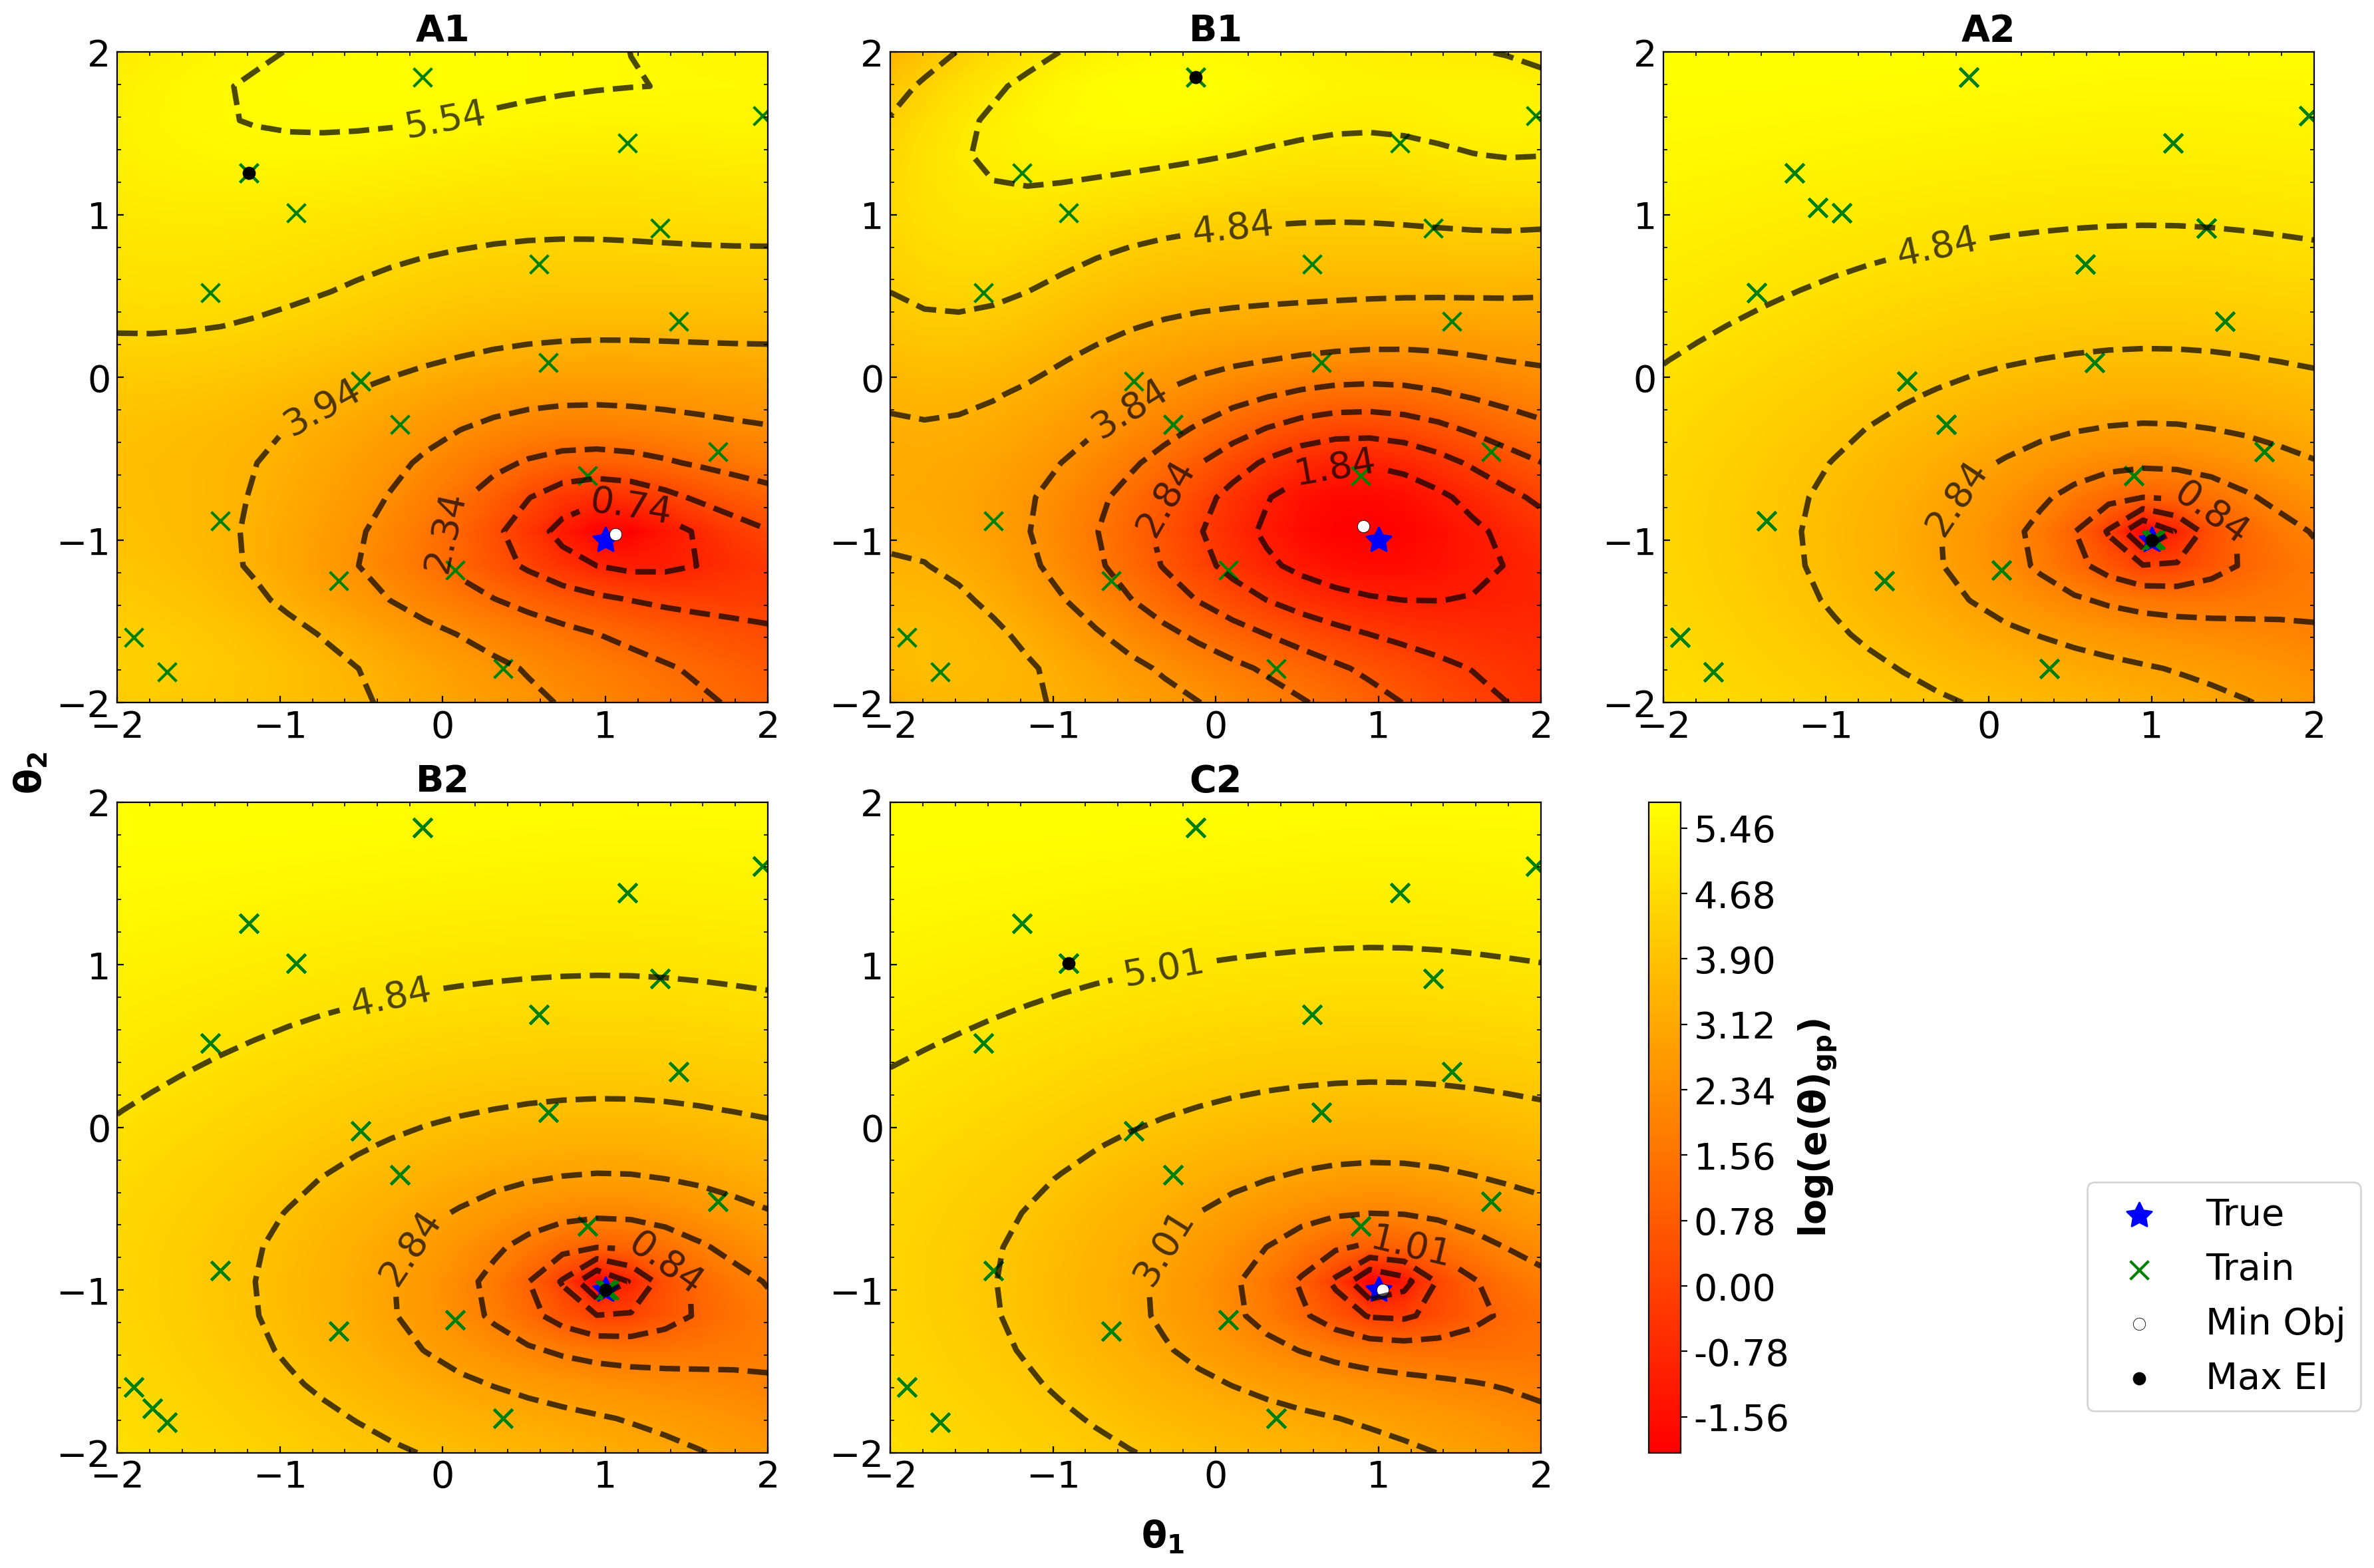

In [9]:
title_fontsize = 24
other_fontsize = 20
xbins = 4
ybins = 5
zbins = 900
save_path = None
cmap = "autumn"
pair = 0
log_data = True

title = "Heat Map Pair "
z_choice = "sse_mean"
title = "Heat Map Pair " + z_choice
title = None
levels = [100,100,100, 100, 100]
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
bo_iter_list = list(map(int, df_best["BO Iter"].to_numpy() + 1))

meth_name_str_list = ["A1", "B1", "A2", "B2", "C2"]

pair = 0

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

compare_method_heat_maps(file_path_list, meth_name_str_list, run_num_list, bo_iter_list, pair, 
                         z_choice, log_data, levels, xbins, ybins, zbins, title, title_fontsize, other_fontsize, 
                         cmap, save_path)

In [6]:
#Plot Muller potential
project = signac.get_project()
meth_name_str_list = [5]
for meth_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_val
    jobs = project.find_jobs(criteria_dict) 
    for job in jobs:
        file_path = job.fn("BO_Results.gz")

    loaded_results = open_file_helper(file_path)
    meth_name = Method_name_enum(loaded_results[0].configuration["Method Name Enum Value"]).name


    run_num = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'Run Number'].iloc[0] + 1
    bo_iter = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'BO Iter'].iloc[0] + 1
    trained_hps = loaded_results[run_num-1].list_gp_emulator_class[bo_iter-1].trained_hyperparams
    print("Method: ", meth_name)
    print("Run Number: ", run_num)
    print("BO Iter Number: ", bo_iter)
    print("Trained Hyperparameters: ", trained_hps)
    x_val_num = 20
    theta_choice = None
    theta_true = loaded_results[run_num-1].simulator_class.theta_true
    theta_choice = theta_true  
#     theta_choice = np.array([-0.12334013, -1.97193209, -9.58736122,  0.70718457]) #(2A Set HPs)
#     theta_choice = np.array([-1.25179735, -1.30799798, -6.38989644,  0.69741102]) #(2A Trained HPs)   
    theta_choice = np.array([-1.52838065,  0.76858661, -8.32826196, -0.15766997]) #(2C Set HPs)

    seed = loaded_results[0].configuration["Seed"]

    title_fontsize = 24
    other_fontsize = 20
    xbins = 4
    ybins = 5
    zbins = 900
    save_path = None
    cmap = "autumn"
    save_path = None

    data_vals = compare_muller_heat_map(file_path, run_num, bo_iter, x_val_num, theta_choice, seed)
    test_mesh, y_sim, gp_mean, gp_var, theta_value, train_X, idcs_to_plot = data_vals
    title = "Heat Map For Theta = " + str(np.round(theta_value,1))

    z = [y_sim]
    z_titles = ["y_sim"]
    
    z = [y_sim,  gp_mean, gp_var]
    z_titles = ["y_sim" , "y_gp", "y_var"]
    
    cmap = "jet"
    levels = [100,100,100]
    plot_axis_names = ["X1", "X2"]
    try:
        plot_heat_maps(test_mesh, None, None, None, train_X, plot_axis_names, levels, idcs_to_plot, z, 
                   z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)
    except:
        pass
print("Max EI Theta", theta_choice)

Method:  C2
Run Number:  2
BO Iter Number:  2
Trained Hyperparameters:  [array([2.85006134, 1.81490763, 0.59961458]), 0.0001, 1]


ValueError: could not broadcast input array from shape (4,) into shape (20,2)